In [1]:
import sys,os,time,cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from th_utils import *
from utils import imread_to_rgb, crop_img, emo2txt
import matplotlib.pyplot as plt


In [2]:
class AffectNet_dataset(Dataset):
    def __init__(self, af_dict, ops):
        self.ops = ops
        self.af_dict = af_dict
        self.len = 287401
    
    def __len__(self):
        return self.len
        
    def __getitem__(self, idx):
        ops = self.ops
        af_dict = self.af_dict
        
        # randomly choose emotion - wrt neutral probability
        rndv = th_rand()
        if rndv < ops.neutral_ratio:
            # neutral
            emo = 6
        else:
            # non neutral, choose again from 0~5
            emo = th_randint(0, 6)
        
        # label vec
        batch_emo = np.zeros(7)
        batch_emo[emo] = 1
        
        # randomly choose image sample and import
        rndi = th_randint(len(af_dict[emo]))
        sel_dict = af_dict[emo][rndi]
        img = imread_to_rgb(ops.affectnet_path + '/Manually_Annotated_Images/' + sel_dict['img'])
        gt = sel_dict['gt']  # (x,y,w,h)
        
        xcen = gt[0] + gt[2]*0.5
        ycen = gt[1] + gt[3]*0.5
        width  = gt[2]
        height = gt[3]
        
        # data augmentation part ==
        aug_prob = ops.aug_prob
        aug_crop = ops.aug_crop
        
        # random crops (always)
        xmod = th_choice([1,-1])*th_rand_rng(0., width*aug_crop)
        ymod = th_choice([1,-1])*th_rand_rng(0., height*aug_crop)
        wmod = 1.0 + th_choice([1,-1])*th_rand_rng(0., aug_crop)
        hmod = 1.0 + th_choice([1,-1])*th_rand_rng(0., aug_crop)
        
        batch_img = crop_img(img, int(xcen+xmod), int(ycen+ymod), int(width*wmod), int(height*hmod), True, True)
        batch_img = cv2.resize(batch_img, (ops.img_sz, ops.img_sz))
        
        # flip horizontally
        if th_rand() < aug_prob:
            batch_img = np.flip(batch_img, axis=1)
            
        # add noise / change level
        if th_rand() < aug_prob:
            noise_std = th_rand()*0.05
            if th_rand() < 0.5:
                noise_img = np.repeat( (noise_std)*torch.randn(ops.img_sz, ops.img_sz, 1), 3, 2)
            else:
                noise_img = (noise_std)*torch.randn(ops.img_sz, ops.img_sz, 3)
            batch_img += noise_img.contiguous().numpy()
        if th_rand() < aug_prob:
            batch_img += (th_rand()-0.5)/50.
        
        # gaussian
        if th_rand() < aug_prob:
            k_sz = th_randint(1,5,2)*2 +1
            batch_img = cv2.GaussianBlur(batch_img, (k_sz[0], k_sz[1]), 0)
        
        # end of data augmentation ==
        
        # reset range [0,1]
        if batch_img.min() < 0.:
            batch_img[ batch_img < 0. ] = 0.
        if batch_img.max() > 1.:
            batch_img[ batch_img > 1. ] = 1.
        
        # returns
        batch_img = torch.Tensor( batch_img.transpose(2,0,1).copy() )
        batch_emo = torch.Tensor( batch_emo.copy() )
        batch_var = torch.Tensor( [sel_dict['val'], sel_dict['aro']] )
        
        return batch_img, batch_emo, batch_var

In [3]:
import ops
af_dict = np.load('../../dicts/affectnet_parsed.npy', allow_pickle=True).item()
af_dataset = AffectNet_dataset(af_dict, ops)
af_loader = DataLoader(dataset=af_dataset, batch_size=ops.batch_size, num_workers=4)


In [4]:
for i, bat in enumerate(af_loader, 0):
    img, emo, var = bat[0], bat[1], bat[2]
    break

In [5]:
img_np = img.permute(0,2,3,1).numpy()

happiness


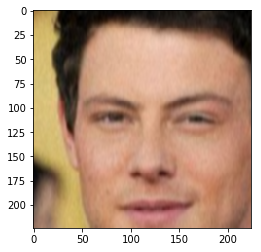

In [6]:
idx = 0
plt.imshow(img_np[idx])
print emo2txt(emo[idx].nonzero()[0][0])

In [17]:
emo_am = emo.argmax(dim=1)
prd_am = 6*torch.ones(16,dtype=int)
print emo_am,prd_am

tensor([3, 6, 1, 3, 6, 6, 6, 6, 6, 5, 2, 6, 6, 5, 0, 4]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])


In [18]:
torch.sum(emo_am == prd_am)

tensor(8)